Task:\
-Smooth map using Gaussian filtre.\
-Pick out 20000 hot and 20000 cold points on map\
-In local peak of angular size 5x5 degrees, calculate T, Qr and Ur and add

In [1]:
# Importing modules required for stacking
import numpy as np
import healpy as hp
import camb
import multiprocessing as mp
from joblib import Parallel, delayed, parallel_backend
from numba import jit

In [2]:
# Importing modules required for maps
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

In [22]:
@jit(nopython=True)
def Qr(Q, U, phi):
    return -Q * np.cos(2 * phi) - U * np.sin(2 * phi)


@jit(nopython=True)
def Ur(Q, U, phi):
    return Q * np.sin(2 * phi) - U * np.cos(2 * phi)


# Generate polarization vectors using Numba
def pol_vec(Q, U):
    phi = 0.5 * np.arctan2(U, Q)
    P = np.sqrt(Q**2 + U**2)
    return phi, P

In [3]:
planck2018pars = camb.read_ini("planck_2018.ini")
planck2018 = camb.get_results(planck2018pars)
powers = planck2018.get_cmb_power_spectra(planck2018pars, CMB_unit="muK", raw_cl=True)

In [10]:
aCl_Total = powers["total"]
almT, almE, almB = hp.synalm(
    [
        np.array(aCl_Total[:, 0]),
        np.array(aCl_Total[:, 1]),
        np.array(aCl_Total[:, 2]),
        np.array(aCl_Total[:, 3]),
    ],
    new=True,
)
sharp_map = hp.alm2map([almT, almE, almB], nside=512)
smooth = hp.smoothing(sharp_map, np.radians(0.5))

In [11]:
index = np.argmax(smooth[0])

In [12]:
lon, lat = hp.pix2ang(512, index, lonlat=True)
pos = hp.ang2vec(lon, lat, lonlat=True)
neigh = hp.query_disc(512, pos, np.radians(np.sqrt(2 * 2.5**2)))
neigh_lon, neigh_lat = hp.pix2ang(512, neigh, lonlat=True)

In [56]:
rot = hp.Rotator(rot=[lon, lat], deg=True)
rot_lon, rot_lat = rot(neigh_lon, neigh_lat)
phi = np.arctan2(rot_lat, rot_lon)
empty_original = np.zeros((3, hp.nside2npix(512)))
Qr_map = np.zeros(hp.nside2npix(512))
Ur_map = np.zeros(hp.nside2npix(512))
for i in range(3):
    empty_original[i, neigh] = smooth[i, neigh]
rot_map = rot.rotate_map_alms(empty_original)
Qr_map[neigh] = Qr(smooth[1, neigh], smooth[2, neigh], phi)
Ur_map[neigh] = Ur(rot_map[1, neigh], rot_map[2, neigh], phi)
Qr_map = rot.rotate_map_alms(Qr_map)
Ur_map = rot.rotate_map_alms(Ur_map)

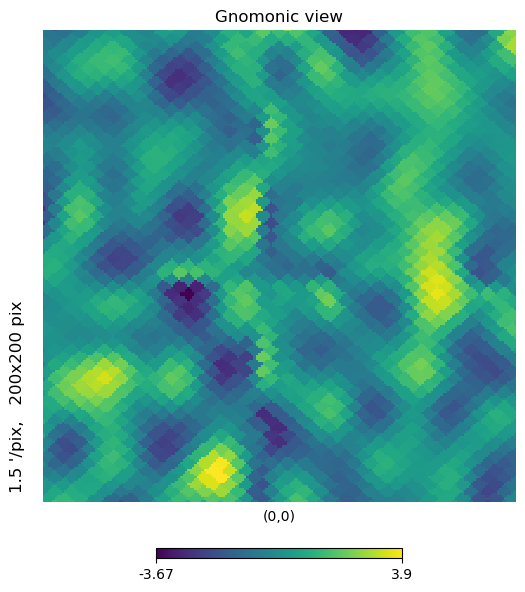

In [58]:
gnom_map = hp.gnomview(
    Qr_map,
    reso=5 * 60 / 200,
    return_projected_map=True,
    no_plot=False,
)

In [3]:
# Functions needed for stacking


# Define Qr and Ur parameters using Numba
@jit(nopython=True)
def Qr(Q, U, phi):
    return -Q * np.cos(2 * phi) - U * np.sin(2 * phi)


@jit(nopython=True)
def Ur(Q, U, phi):
    return Q * np.sin(2 * phi) - U * np.cos(2 * phi)


# Convert longitude and latitude to angle from east using Numba
@jit(nopython=True)
def east_phi(lon_c, lat_c, lon_p, lat_p):
    dlon = np.radians(lon_p - lon_c)
    dlat = np.radians(lat_p - lat_c)
    return np.arctan2(dlat, dlon)


# Generate polarization vectors using Numba
@jit(nopython=True)
def pol_vec(Q, U):
    psi = 0.5 * np.arctan2(U, Q)
    P = np.sqrt(Q**2 + U**2)
    return psi, P

In [13]:
# Functions needed for plots


# Function to create inputs for vector map
def vectormap(step, Q, U):
    sample_row = np.arange(0, 200, step)
    sample_col = np.arange(0, 200, step)
    psi, P = pol_vec(
        Q[np.ix_(sample_row, sample_col)], U[np.ix_(sample_row, sample_col)]
    )
    x, y = np.meshgrid(
        np.arange(-2.5, 2.5, step / 200 * 5), np.arange(-2.5, 2.5, step / 200 * 5)
    )
    u = P * np.cos(psi)
    v = P * np.sin(psi)
    return x, y, u, v


# Compute vectormap data once
def compute_vectormaps(average, step):
    x_dict, y_dict, u_dict, v_dict = {}, {}, {}, {}
    for minmax in range(2):
        x, y, ur, vr = vectormap(
            step, average[minmax, 3, :, :], average[minmax, 4, :, :]
        )
        x_dict[minmax] = x
        y_dict[minmax] = y
        u_dict["Qr"] = ur
        v_dict["Qr"] = vr
        u_dict["Ur"] = ur
        v_dict["Ur"] = vr

    return x_dict, y_dict, u_dict, v_dict


# Function for plotting
def plot_param(ax, im_data, x, y, u, v, params, minmax, quiver_params=None):
    im = ax.imshow(im_data, extent=(-2.5, 2.5, -2.5, 2.5), cmap="coolwarm")
    ax.grid()
    ax.set_xlabel("Degrees")
    ax.set_ylabel("Degrees")
    ax.set_title(f"Average of the {'maxima' if minmax == 0 else 'minima'} of {params}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="20%", pad=0.05)
    plt.colorbar(im, cax=cax, format="%.2f")

    if quiver_params:
        ax.quiver(x, y, u, v, scale=15, headwidth=1, color="black")

In [9]:
# Function to compute data for one peak with an index
def process_peak(smooth_map, index, minmax, j, nside):
    # Find angular coordinates of longitude and latitude of the given peak
    lon, lat = hp.pix2ang(nside, index[minmax, j], lonlat=True)
    # position vector of the peak
    pos = hp.ang2vec(lon, lat, lonlat=True)
    # Find neighbours in a 5x5 degree area centred at the central point
    neigh = hp.query_disc(nside, pos, np.radians(np.sqrt(2 * 2.5**2)))
    neigh_lon, neigh_lat = hp.pix2ang(nside, neigh, lonlat=True)
    # getting angluar coordinates of tbe neighbour points
    phi = east_phi(lon, lat, neigh_lon, neigh_lat)
    # array of values of an empty map which will then be filled by data of neighbours
    empty = np.zeros((5, hp.nside2npix(nside)))
    # array for the map of the neighbours of this peak
    result = np.zeros((5, 200, 200))
    # loop for each parameter
    for pindx in range(5):
        if pindx < 3:
            empty[pindx, neigh] = smooth_map[pindx, neigh]
        elif pindx == 3:
            empty[pindx, neigh] = Qr(smooth_map[1, neigh], smooth_map[2, neigh], phi)
        else:
            empty[pindx, neigh] = Ur(smooth_map[1, neigh], smooth_map[2, neigh], phi)
        gnom_map = hp.gnomview(
            empty[pindx, :],
            rot=(lon, lat),
            reso=5 * 60 / 200,
            return_projected_map=True,
            no_plot=True,
        )
        result[pindx, :, :] = gnom_map
    return minmax, result


def stack_cmb_params(no_spots, lensing=True, nside=512):
    # Use input initial params to generate CMB spectra
    planck2018pars = camb.read_ini("planck_2018.ini")
    planck2018 = camb.get_results(planck2018pars)
    powers = planck2018.get_cmb_power_spectra(
        planck2018pars, CMB_unit="muK", raw_cl=True
    )
    if lensing == True:
        aCl_Total = powers["total"]
    else:
        aCl_Total = powers["unlensed_total"]
    almT, almE, almB = hp.synalm(
        [
            np.array(aCl_Total[:, 0]),
            np.array(aCl_Total[:, 1]),
            np.array(aCl_Total[:, 2]),
            np.array(aCl_Total[:, 3]),
        ],
        new=True,
    )
    sharp_map = hp.alm2map([almT, almE, almB], nside=nside)
    smooth = hp.smoothing(sharp_map, np.radians(0.5))

    index = np.array(
        [np.argsort(smooth[0])[-no_spots:], np.argsort(smooth[0])[:no_spots]]
    )

    # Initialize the final stacked array
    stacked = np.zeros((2, 5, 200, 200))

    # Set multiprocessing start method to 'spawn' or 'forkserver'
    mp.set_start_method("spawn", force=True)
    with parallel_backend("loky"):
        results = Parallel(n_jobs=-1)(
            delayed(process_peak)(smooth, index, minmax, j, nside)
            for minmax in range(2)
            for j in range(no_spots)
        )
    for minmax, result in results:
        stacked[minmax, :, :, :] += result
    stacked /= no_spots
    return stacked

In [10]:
# Run function
peaks = 20
lensed = stack_cmb_params(peaks)
nolens = stack_cmb_params(peaks)

In [11]:
# vector sample step
step = 8
x_dict, y_dict, ul_dict, vl_dict = compute_vectormaps(lensed, step)
x_dict, y_dict, un_dict, vn_dict = compute_vectormaps(nolens, step)

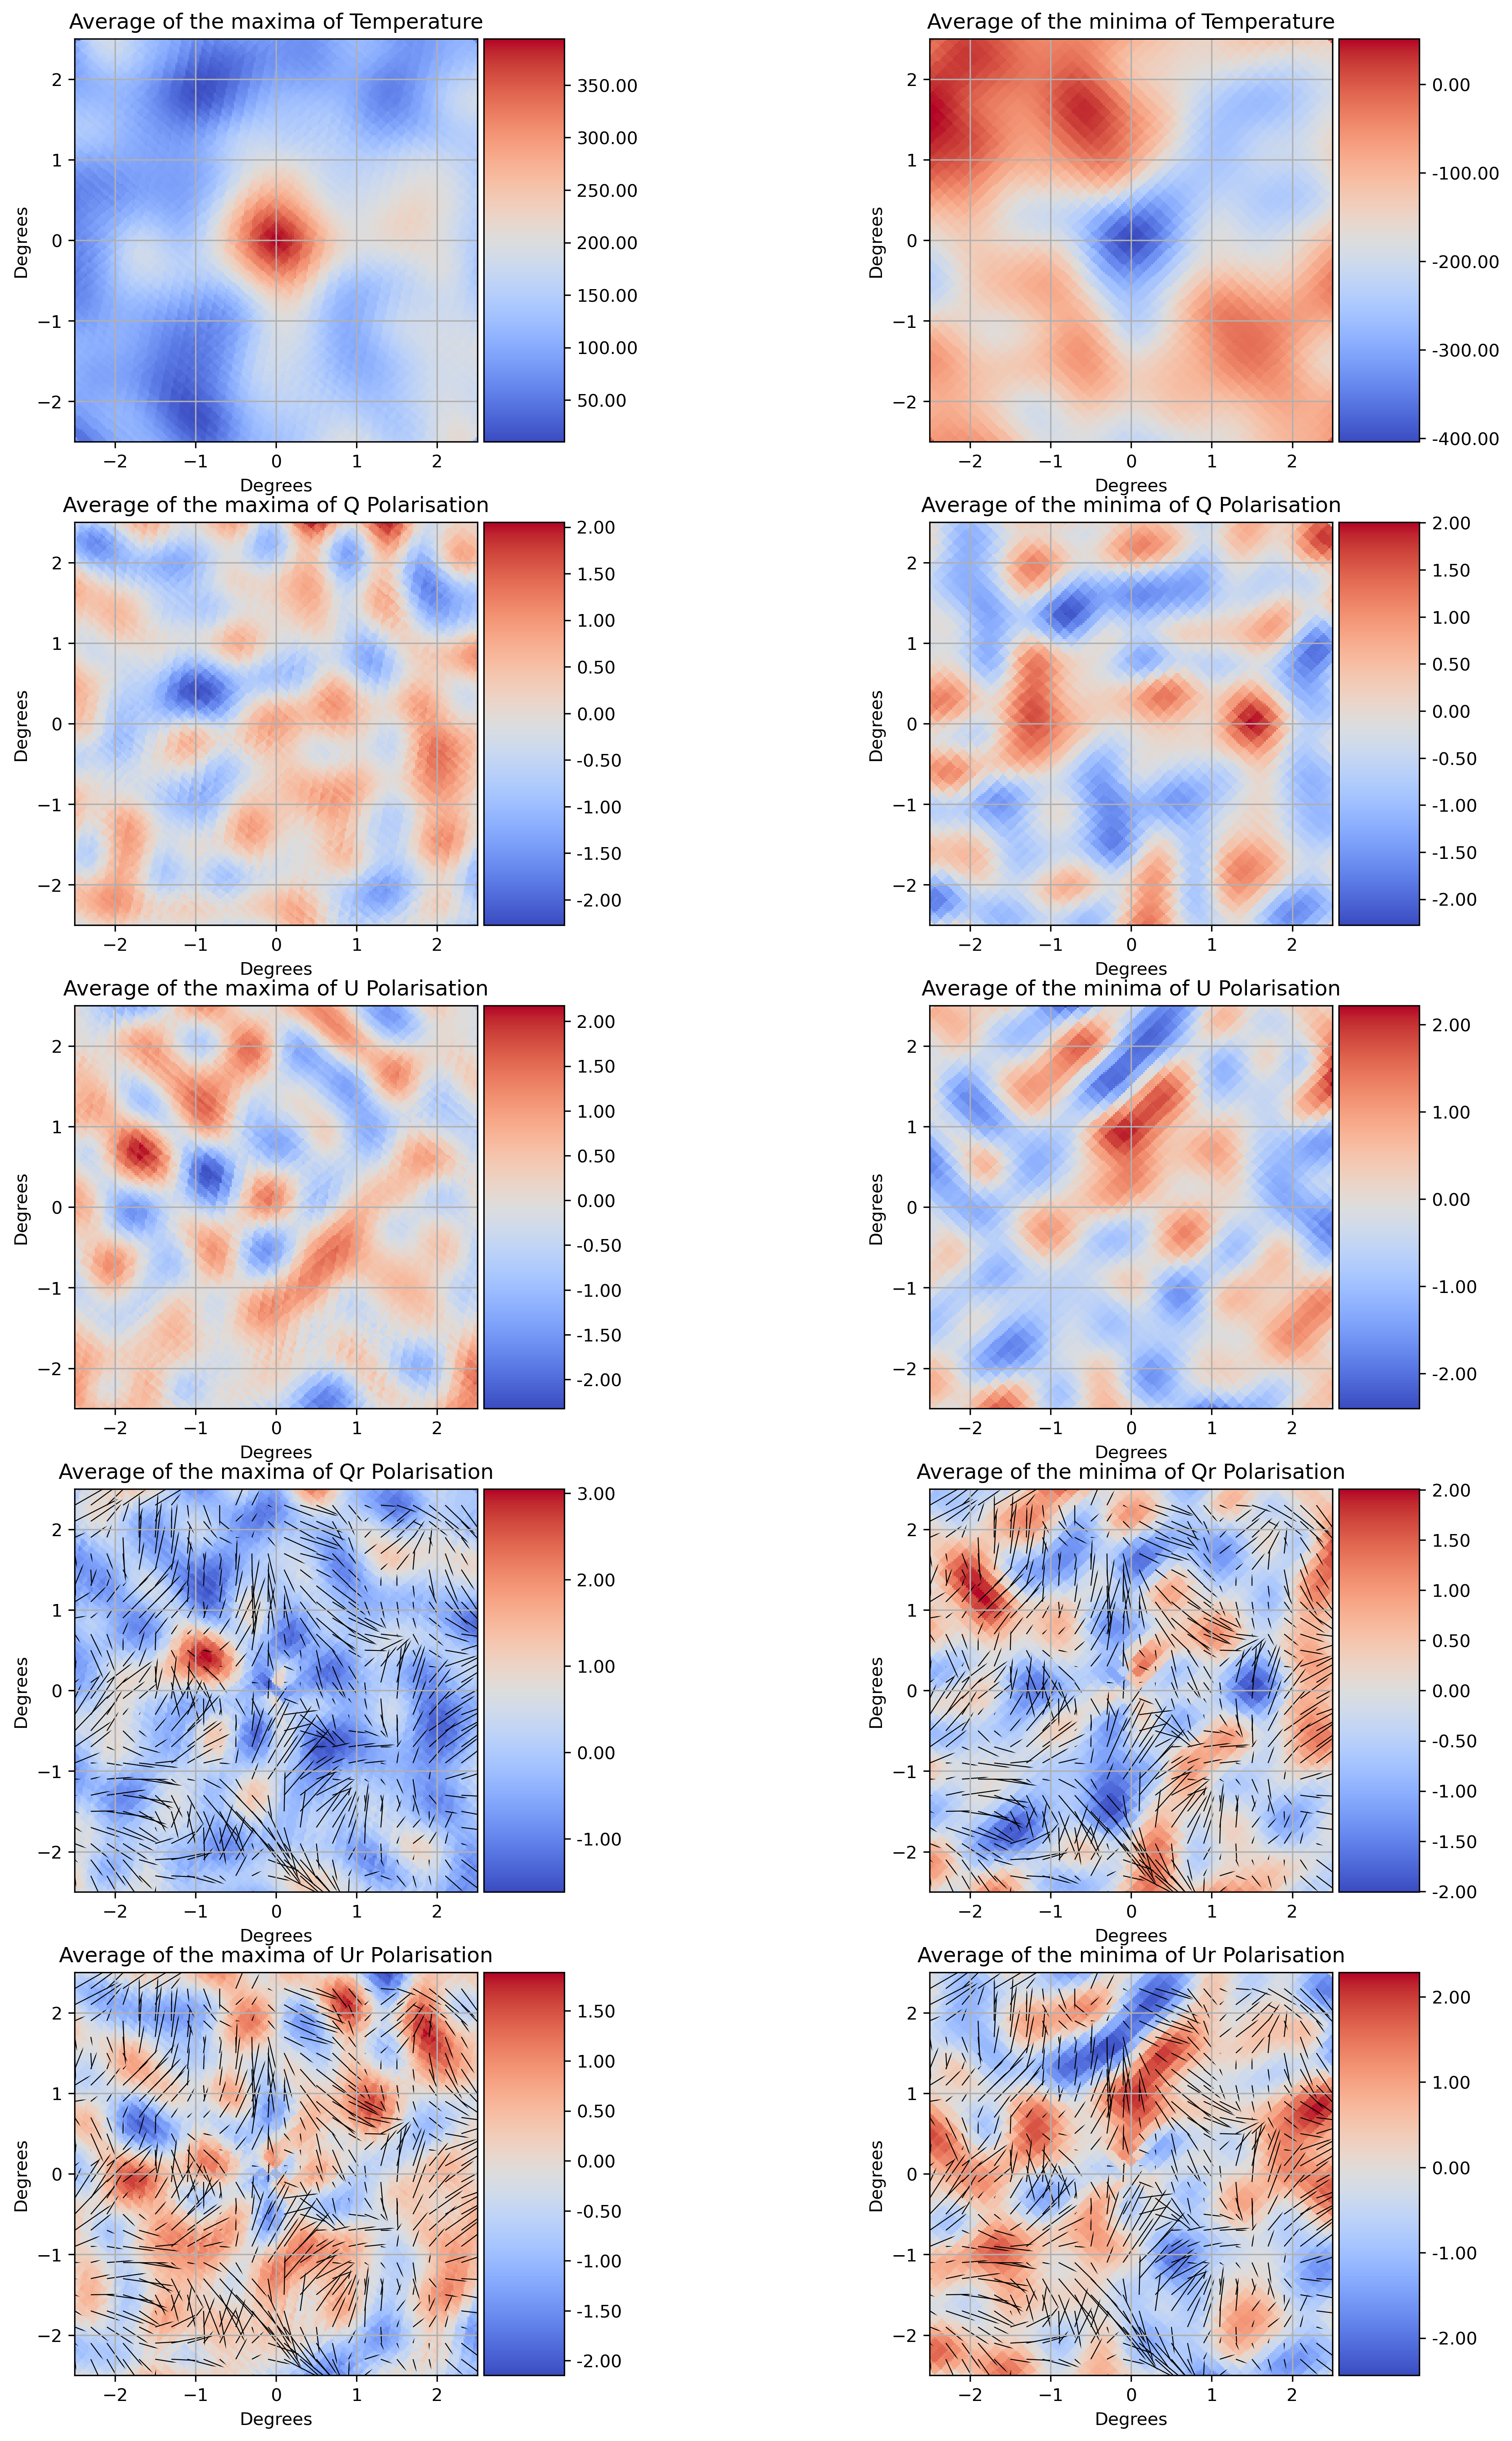

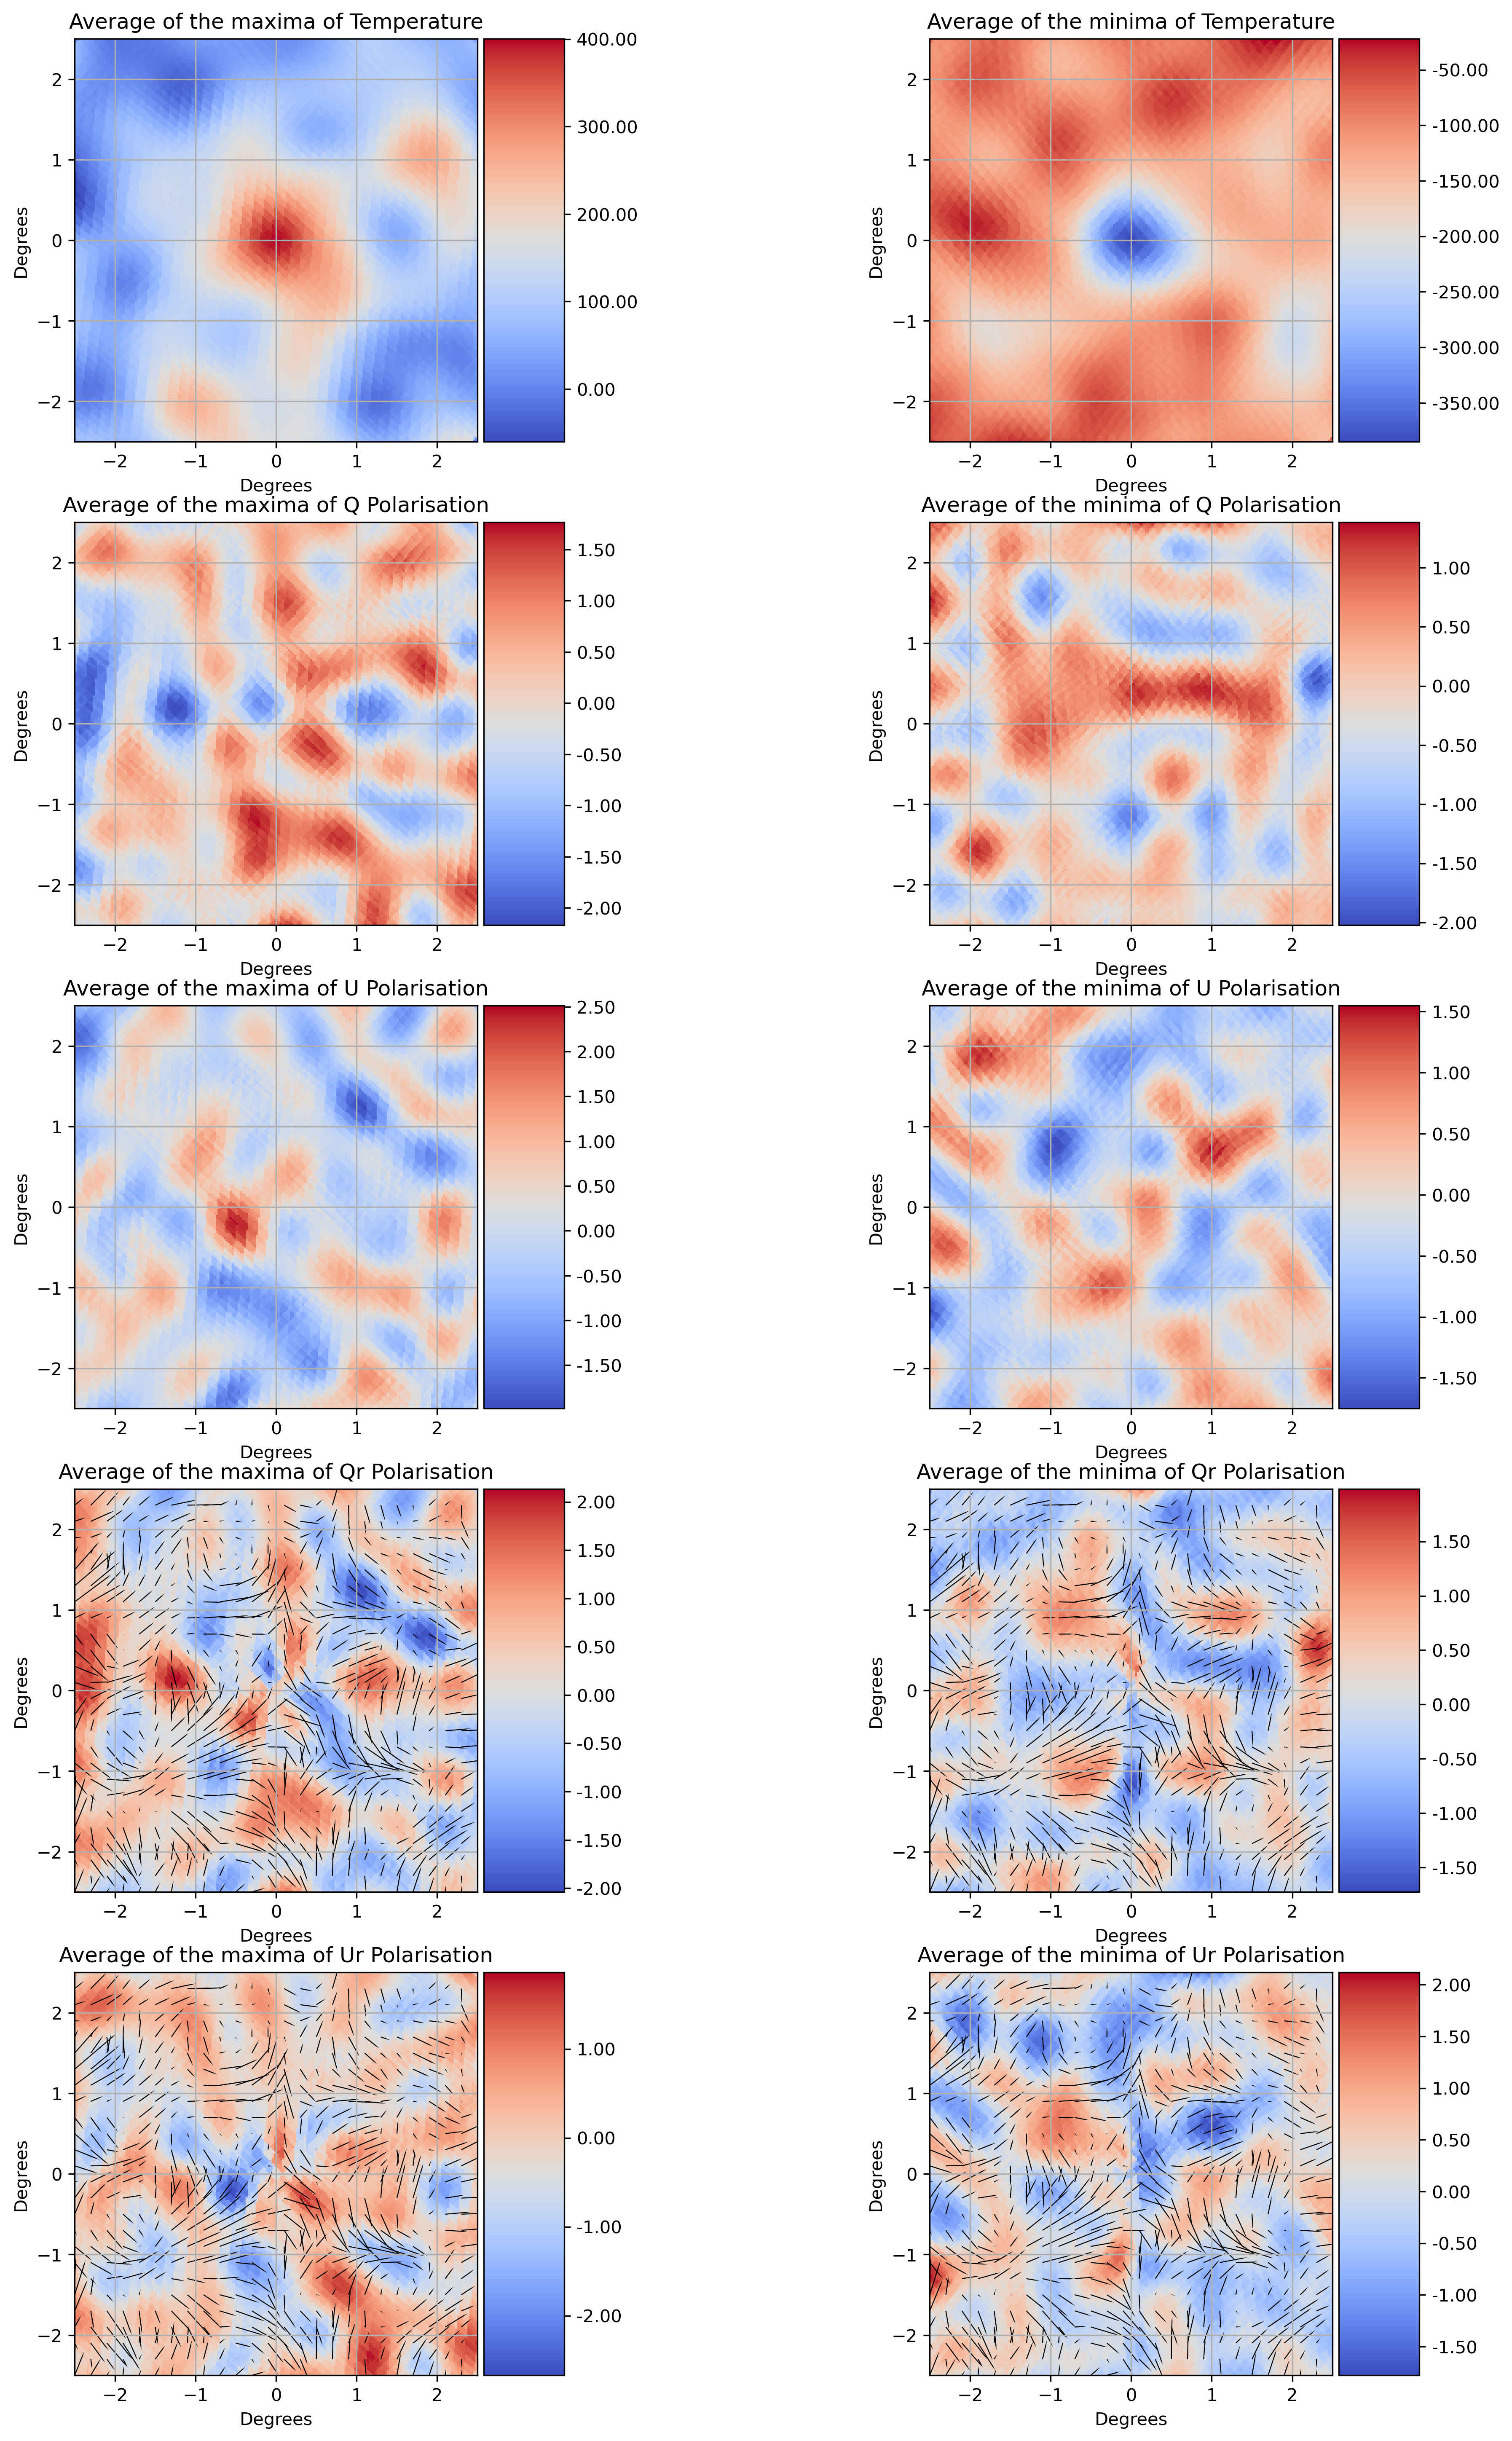

In [14]:
# Create figures
figl, axl = plt.subplots(5, 2, figsize=(16, 24), dpi=300)
fign, axn = plt.subplots(5, 2, figsize=(16, 24), dpi=300)

for minmax in range(2):
    for params, name in zip(
        range(5),
        [
            "Temperature",
            "Q Polarisation",
            "U Polarisation",
            "Qr Polarisation",
            "Ur Polarisation",
        ],
    ):
        # lensed plot
        quiver_params = None
        if params == 3:
            quiver_params = "Qr"
        elif params == 4:
            quiver_params = "Ur"

        plot_param(
            axl[params, minmax],
            lensed[minmax, params, :, :],
            x_dict[minmax],
            y_dict[minmax],
            ul_dict.get(quiver_params, None),
            vl_dict.get(quiver_params, None),
            name,
            minmax,
            quiver_params,
        )

        # no lens plot

        plot_param(
            axn[params, minmax],
            nolens[minmax, params, :, :],
            x_dict[minmax],
            y_dict[minmax],
            un_dict.get(quiver_params, None),
            vn_dict.get(quiver_params, None),
            name,
            minmax,
            quiver_params,
        )

# Save figures
figl.savefig("Output/Lensed_Average.png")
fign.savefig("Output/Nolensed_Average.png")

plt.show()